# Table of Contents
- Transfer Learning
- [Exercises](#exercises)

# Housekeeping
- Some references for today
  - [Official pytorch tutorials](https://pytorch.org/tutorials/)
  - [Pytorch tutorials by yunjey, from beginning to advanced](https://github.com/yunjey/pytorch-tutorial)
  - [Deep Learning Book on ConvNets](https://www.deeplearningbook.org/contents/convnets.html)
  - [pytorch tutorial on transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
  - [pytorch tutorial on finetuning](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)
- Today's url
  - https://git.io/ml2021-09
- Email if you need help with any of this!

# Transfer Learning: Introduction
- With modern, state-of-the-art, deep networks, training can take many
  days or weeks of GPU time and require millions of datapoints
- The classic ILSVRC ImageNet 2010 challenge asks for a classifier to
  separate 1000 categories, with > 1000 high-resolution test images
  per category
- Obviously, not everyone will be able to train a network to do this
  from scratch, not everyone can spend weeks of time on modern GPUs
- Nor would you necessarily want to: if you need weeks of time to
  train a model, it'll be annoying to find out you used a not great
  model!
- This brings us to *Transfer Learning*
  - Use a pretrained model, where most of the hard work has been done,
    and simply finetuning it to solve the problem you're interested in
  - For this to really make sense, the data of the new sample should
    have features which have been trained into the pretrained network
  - So, repurposing a general purpose image detector to classify dog
    breeds would be sensible, taking the image network and retuning it
    to play go (바둑) would not be, you should train that from scratch

# Transfer Learning


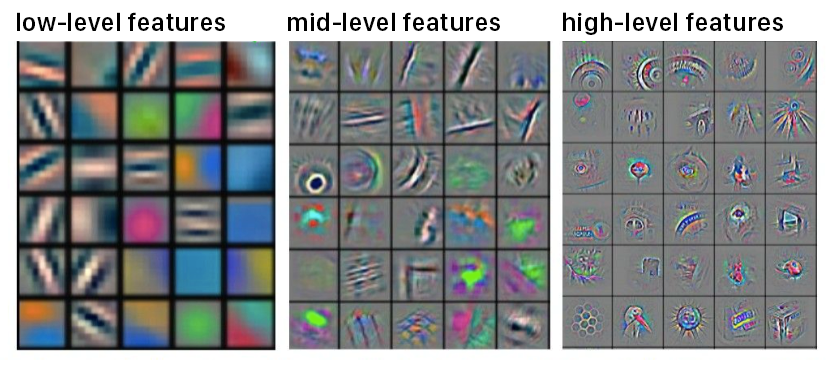

In [ ]:
from IPython.display import Image
Image("../../2020-deep-learning/06-convolutions/features.png", width=180)

- Images which filters at different layers strongly activate on
- The network has been trained on ILSVRC to label real world images
- If we look at the various layers of filters, the early filters will
  be useful generally, the middle filters will be useful for most
  tasks, and the later filters will be fine for a large range of real
  world images
- So, we can take a model trained on ILSVRC (> 1 million high-res
  images), and then retrain to our dataset
  - Requires less time and we can get away with a smaller dataset
Image from https://twopointseven.github.io/2017-10-29/cnn/

# Pretrained Models in Torchvision, and Transfer Learning
- For transfer learning, we need change the final output layer to a
  new layer with the right number of outputs for our problem
- Then, we can either:
  - Fix the parameters of the pre-trained model and simply train the final layer
  - Finetune all the parameters, including the pretrained model, at
    once
  - Do the final layer training, then another step to finetune the
    remaining parameters
- Torchvision has a set of pretrained models we can do this on:
  https://pytorch.org/docs/stable/torchvision/models.html

# VGG Networks

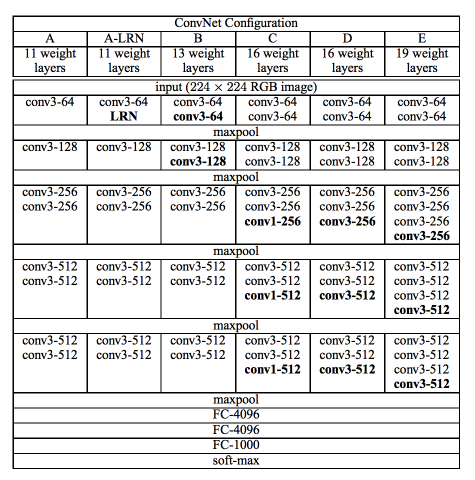

In [ ]:
Image("vgg.png", width=160)

- References: [VGG in PyTorch](ttps://pytorch.org/hub/pytorch_vision_vgg/) and the original [VGG paper](https://arxiv.org/abs/1409.1556)
- First place in the 2014 ImageNet Challenge
- Structured as a series of conv layers, followed by fully connected layer
  - The typical structure we've been looking at for the past few weeks
- Input is 224x224 RGB images, with the inputs normalized to mean 
  $= (0.485,0.456,0.406)$ and std $= (0.229,0.224,0.225)$
  - That is, the network is trained with images where the distribution
    of pixel values across the image has been normalized to these
    numbers (per channel)
  - [Torchvision has a Normalize transform](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize) which you can use
    - `output[i] = (input[i] - mean[i]) / std[i]` for each channel `i`


# VGG11


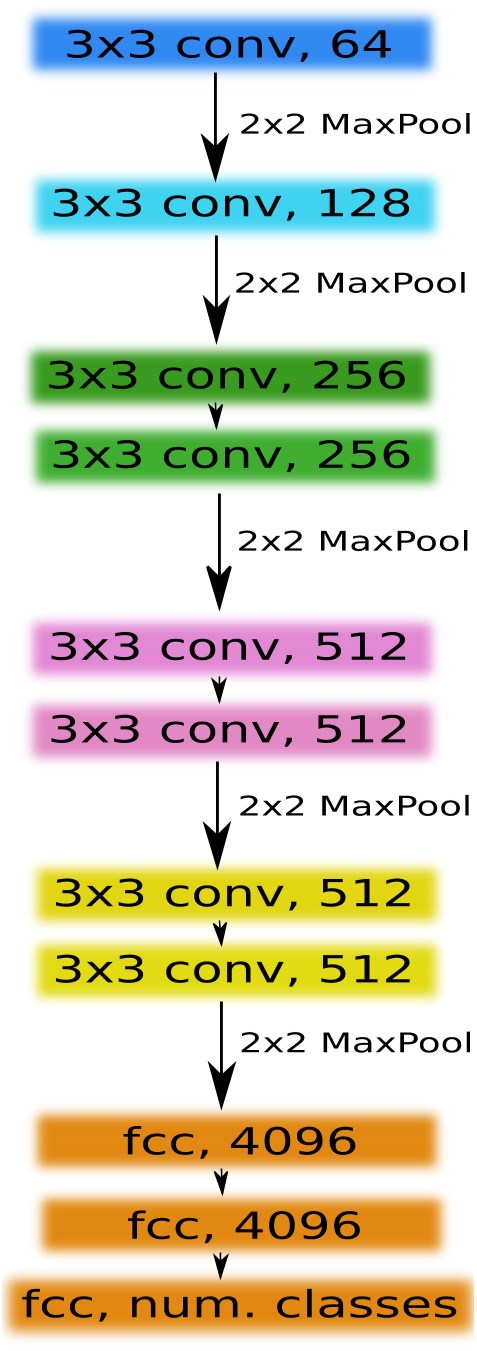

In [ ]:
Image("vggnet.jpg", width=160)

- Today, we'll try the smallest VGG network option, VGG11
- The networks are *huge* so it will be hard to load and train anything bigger on colab
- Here is VGG11 laid out showing the layers of the network
- Each convolution and fcc layer (except the final) is followed by a ReLU activation
# Replacing a Layer
- We can load a 11-layer VGG with torchvision and check the structure

In [ ]:
import torchvision
net = torchvision.models.vgg11(pretrained=True)
net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

- We can see the last layer (which we can access as
  `net.classifier[6]`) has 4096 inputs and 1000 outputs

# Sequential

- We may want to replace the last layer with a complicated new setup
- We could just build a `torch.nn.Module` and use that as a layer
  (pytorch lets you hook these in anywhere you would expect a layer)
- For these type of simple setups, we can use `Sequential` instead, it
  takes in layers (like you would setup in the `__init__`), and
  connects them sequentially, i.e. the output of one layer goes to the
  output of the next
  - This is usually what are models do, but note, you can't
    e.g. change the `shape` of the tensor as it goes through the
    layers, so doesn't completely replace `nn.Module`

Example, creating a fully connected layer which passes through a sigmoid

In [ ]:
import torch.nn as nn
nn.Sequential(nn.Linear(4096,10), nn.Sigmoid())

Sequential(
  (0): Linear(in_features=4096, out_features=10, bias=True)
  (1): Sigmoid()
)

And replace the final classifier layer of our VGG with it:

In [ ]:
net.classifier[6] = nn.Sequential(nn.Linear(4096,10), nn.Sigmoid())

The `net` still works the same, but now it has only 10 outputs!

# Net after our replacement

Try running the code from the last few pages and see you get this network:

In [ ]:
net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

# Example of Fashion MNIST
- Walk through of a complete example
- I recommend you run each command yourself on colab, to see it in action

Download the data. We need to transform the FashionMNIST into an input
that VGG11 can handle, this means upscaling to 224x224 and making a 3
channel image with the right normalization. With a small b&w dataset
like FashionMNIST, its not really sensible to run it through a color
network, but we'll do it just as an easy test case.

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
trans = transforms.Compose([
  transforms.Resize(224), # upscale from 28x28 to 224x224
  transforms.Grayscale(3), # turns it into a 3 color image with channels r==g==b
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train = torchvision.datasets.FashionMNIST('torchvision/FashionMNIST', train=True, download=True, transform=trans)
test = torchvision.datasets.FashionMNIST('torchvision/FashionMNIST', train=False, download=True, transform=trans)
trainloader = torch.utils.data.DataLoader(train, batch_size=64, num_workers=4)
testloader = torch.utils.data.DataLoader(test, batch_size=64, num_workers=4)

Download the VGG11 pretrained network from torchvision and check its structure

In [ ]:
net = torchvision.models.vgg11(pretrained=True)
net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

We will start by recreating and retraining the last layer, so we turn
off all the `requires_grad`, as they won't be optimized, so we don't
need to keep track of their gradient (computationally expensive!).

In [ ]:
for p in net.parameters():
  p.requires_grad = False

The FashionMNIST problem needs 10 outputs, so lets change the final
layer. We can access named layers through the `.` notation as members
of the object, and numbered layers are list indices. We need to change
the 6th layer of the `classifier` layer to a fully connected layer
with 4096 inputs and 10 outputs.

In [ ]:
net.classifier[6] = torch.nn.Linear(4096, 10)
net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

Now we can run an optimization loop. We pass only parameters that have
`requires_grad=True` to the optimizer i.e. only the parameters of the
last layer.
(Note: this is computationally expensive (it will try to process 64
images on the GPU at a time, so needs 64 copies of the network), if
you get an out of memory error on colab, you will need to change the
batch size to less than 64, maybe even 8 or less).

In [ ]:
params = []
for p in net.parameters():
  if p.requires_grad:
    params.append(p)
# we only pass the final layer to optim, so it only tries to update
# the layer parameters, not the rest of the network which we have fixed
optim = torch.optim.SGD(params, lr=1e-2, momentum=0.9)
loss = torch.nn.CrossEntropyLoss()
d = torch.device('cuda')
net = net.to(d)
dtrain, dtest = [], []
for epoch in range(2):
  tl,tn = 0.,0.
  for ii, (i, o) in enumerate(trainloader):
    _ = net.train()
    i,o = i.to(d), o.long().to(d)
    optim.zero_grad()
    l = loss(net(i), o)
    l.backward()
    optim.step()
    tl+=l.item()*i.size(0)
    tn+=i.size(0)
    if (ii+1) % 200 == 0:
      print("epoch", epoch, "batch", ii, tl/tn)
      dtrain.append(tl/tn)
      tl,tn = 0.,0.
      _ = net.eval()
      for i, o in testloader:
        with torch.no_grad():
          l = loss(net(i.to(d)), o.to(d))
        tl+=l.item()*i.size(0)
        tn+=i.size(0)
      dtest.append(tl/tn)
      print(" test", epoch, "batch", ii, tl/tn)
      tl,tn = 0.,0.

print("Done")

epoch 0 batch 199 1.0378159408271312
 test 0 batch 199 0.7187711295127869
epoch 0 batch 399 1.0121363052725791
 test 0 batch 399 0.6276459149360657
epoch 0 batch 599 1.0967699918150902
 test 0 batch 599 0.6155599884986878
epoch 0 batch 799 1.030938462615013
 test 0 batch 799 0.7061588558197022
epoch 1 batch 199 1.031617591381073
 test 1 batch 199 0.6941776229858398
epoch 1 batch 399 1.010278778374195
 test 1 batch 399 0.6014661114692688
epoch 1 batch 599 0.9744768467545509
 test 1 batch 599 0.6308181045532226
epoch 1 batch 799 1.0309074980020523
 test 1 batch 799 0.8436077212333679
Done


When comparing the training and test losses, remember that there are
several Dropout layers in VGG11 so they are not directly comparable.
Overall, the result isn't great. Thats not unexpected since we're
upsampling a grayscale image and checking it for features that have
been optimized to higher resolution color images. Lets finetune the
entire network and see how we go. We need to set `require_grad` back
to `True` for all the network parameters, then create a new optimizer
for the whole network. 

In [ ]:
for p in net.parameters():
  p.requires_grad = True
# New optimizer which can optimize the whole network
optim = torch.optim.SGD(net.parameters(), lr=1e-4, momentum=0.9)
dtrain, dtest = [], []
for epoch in range(2):
  tl,tn = 0.,0.
  for ii, (i, o) in enumerate(trainloader):
    _ = net.train()
    i,o = i.to(d), o.long().to(d)
    optim.zero_grad()
    l = loss(net(i), o)
    l.backward()
    optim.step()
    tl+=l.item()*i.size(0)
    tn+=i.size(0)
    if (ii+1) % 200 == 0:
      print("epoch", epoch, "batch", ii, tl/tn)
      dtrain.append(tl/tn)
      tl,tn = 0.,0.
      _ = net.eval()
      for i, o in testloader:
        with torch.no_grad():
          l = loss(net(i.to(d)), o.to(d))
        tl+=l.item()*i.size(0)
        tn+=i.size(0)
      dtest.append(tl/tn)
      print(" test", epoch, "batch", ii, tl/tn)
      tl,tn = 0.,0.

print("Done")

You probably did much better with your own small network the other
week, but that should give you an idea of how to transfer learn with
pytorch. As to why its slow check the number of parameters:

In [ ]:
# net.parameters() gives a list of the parameters (which itself is
# basically a list of weight) for each layer of the network, p.numel()
# returns the number of weights for the layer
sum(p.numel() for p in net.parameters())

128807306

We are trying to optimize *over 128 million* weights! We will see a
more compact networks which keep the good performance next week.

# The Galaxy Zoo

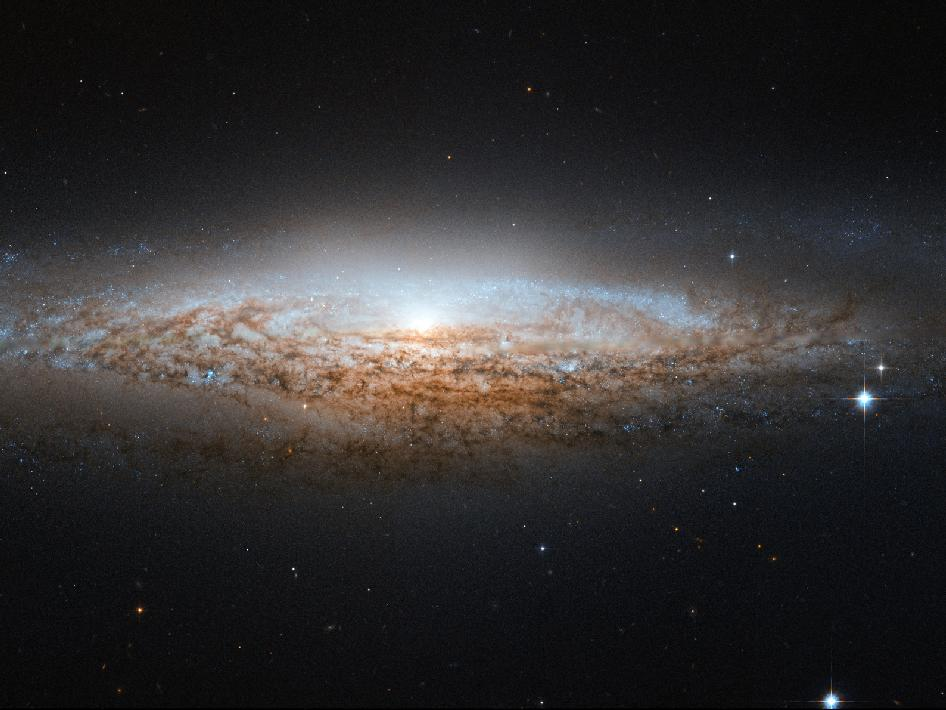

In [ ]:
Image("galaxy_image.jpg", width=160)

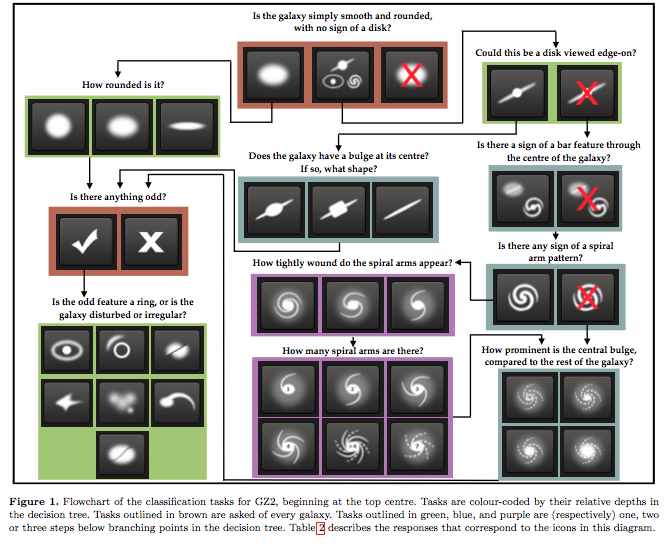

In [ ]:
Image("decision_tree.png", width=160)

- The galaxy zoo is a citizen science project: webusers are given
  galaxy images from the sloan digital sky survey and asked to answer
  a survey about the galaxy (multiple paths)
- The full challenge requires the classifier to predict the responses
  to the full questionaire, what fraction of the respondents answer
  yes to each (paths not gone done are assigned no)
  - So, it seems like a classification task, but really its a
    multi-output regression problem

See e.g. the [kaggle challenge](https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge)


# Exercises <a id="exercises" />

We will again look at the galaxy zoo, this time using transfer
learning to take a pretrained model and use it to train the regression
network.

- We will take a pretrained model and rerun it to solve a simplified version of the galaxy zoo:
  - Instead of predicting the output of all questions, we will try to
    predict the output of just one of the questions: does the galaxy
    have spiral arms? i.e. the classifier should answer the question:
    is our image an image of a spiral galaxy?
  - (Or rather, what fraction of webusers would say that this image is
    an image of a spiral galaxy)

0. Load the galaxy zoo.

On colab, download the images and the labels and extract them, or on gate just set the directory

In [2]:
# if on colab
!gdown https://drive.google.com/uc?id=1kXTFPIOp6ctIn4RJ8RoxMhklulpC6SV9
!gdown https://drive.google.com/uc?id=1cBCgj-9bnsW91X4vEiuNm8Ms4XJ3MfYo
!unzip training_solutions_rev1.zip
!unzip images_training_rev1.zip
!ls -l
dir = '.'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: images_training_rev1/926462.jpg  
  inflating: images_training_rev1/926478.jpg  
  inflating: images_training_rev1/926480.jpg  
  inflating: images_training_rev1/926484.jpg  
  inflating: images_training_rev1/926488.jpg  
  inflating: images_training_rev1/926509.jpg  
  inflating: images_training_rev1/926522.jpg  
  inflating: images_training_rev1/926544.jpg  
  inflating: images_training_rev1/926547.jpg  
  inflating: images_training_rev1/926548.jpg  
  inflating: images_training_rev1/926551.jpg  
  inflating: images_training_rev1/926602.jpg  
  inflating: images_training_rev1/926630.jpg  
  inflating: images_training_rev1/926649.jpg  
  inflating: images_training_rev1/926655.jpg  
  inflating: images_training_rev1/926657.jpg  
  inflating: images_training_rev1/926675.jpg  
  inflating: images_training_rev1/926676.jpg  
  inflating: images_training_rev1/926696.jpg  
  inflating: images_training_rev1/926725.jpg  
  inflating: images_trai

In [ ]:
# if on gate
dir='/store/user/iawatson/galaxy-zoo'

Here are some dataloaders you can use. It splits the dataset into 90%
training and 10% testing. Its slightly different from last week, as
the transforms are set up to resize the images to 224x224 which is the
input size VGG expects, and normalizes the channels to the expected
values.

In [3]:
import torchvision as tv
import torch as th
import pandas as pd
import PIL
import matplotlib.pyplot as plt

In [4]:
class ZooTrain(object):
  def __init__(self, transforms=tv.transforms.Compose([tv.transforms.ToTensor()])):
    self.csv = pd.read_csv(f'{dir}/training_solutions_rev1.csv')
    self.id = self.csv["GalaxyID"].values[:int(9*len(self.csv)/10)]
    self.spiral = self.csv["Class4.1"].values[:int(9*len(self.csv)/10)]
    self.transforms = transforms
  def __getitem__(self, idx):
    return (self.transforms(PIL.Image.open(f"{dir}/images_training_rev1/{self.id[idx]}.jpg")), 
            th.tensor(self.spiral[idx]))
  def __len__(self):
    return len(self.spiral)

class ZooTest(object):
  def __init__(self, transforms=tv.transforms.Compose([tv.transforms.ToTensor()])):
    self.csv = pd.read_csv(f'{dir}/training_solutions_rev1.csv')
    self.id = self.csv["GalaxyID"].values[int(9*len(self.csv)/10):]
    self.spiral = self.csv["Class4.1"].values[int(9*len(self.csv)/10):]
    self.transforms = transforms
  def __getitem__(self, idx):
    return (self.transforms(PIL.Image.open(f"{dir}/images_training_rev1/{self.id[idx]}.jpg")), 
            th.tensor(self.spiral[idx]))
  def __len__(self):
    return len(self.spiral)

tr = tv.transforms.Compose([
  tv.transforms.Resize(224),
  tv.transforms.ToTensor(),
  tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
zoo_train_ = ZooTrain(tr)

tr = tv.transforms.Compose([
  tv.transforms.Resize(224),
  tv.transforms.ToTensor(),
  tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
zoo_test_ = ZooTest(tr)
tr = tv.transforms.Compose([
  tv.transforms.Resize(224),
  tv.transforms.ToTensor(),
  #tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
print_test = ZooTest(tr)
zoo_train = th.utils.data.DataLoader(zoo_train_, batch_size=8, num_workers=1)
zoo_test = th.utils.data.DataLoader(zoo_test_, batch_size=8, num_workers=1)

1. Display the first 5 images from the galaxy zoo dataset and write
   out the fraction of respondents who classified each image a spiral
   galaxy (our target variable).


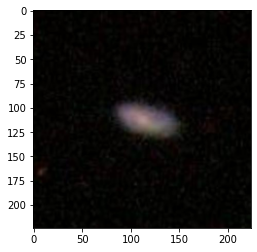

tensor(0., dtype=torch.float64)


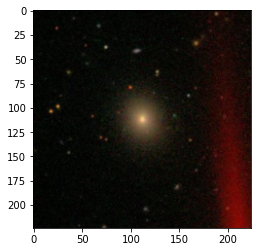

tensor(0., dtype=torch.float64)


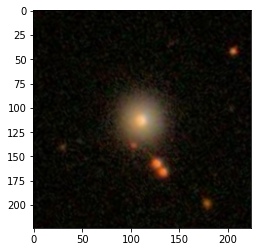

tensor(0., dtype=torch.float64)


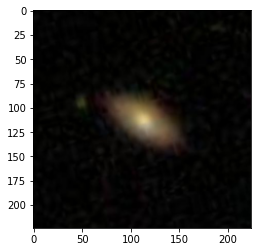

tensor(0.1957, dtype=torch.float64)


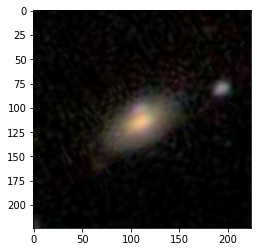

tensor(0., dtype=torch.float64)


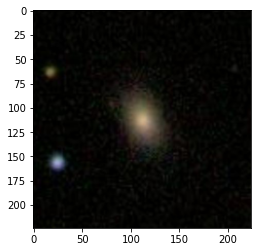

tensor(0., dtype=torch.float64)


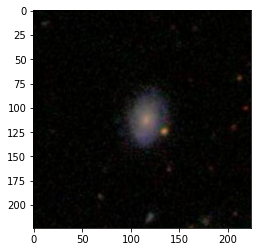

tensor(0.4367, dtype=torch.float64)


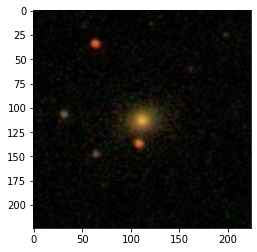

tensor(0., dtype=torch.float64)


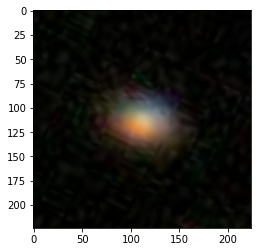

tensor(0.0227, dtype=torch.float64)


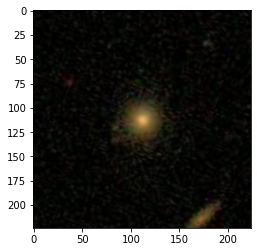

tensor(0., dtype=torch.float64)


In [7]:
num = 0 
ch = False
for x, y in (print_test):
  plt.imshow(x.permute((1,2,0)))
  plt.show()
  print(y)
  num+=1
  if num == 10:
    break
  

2. Load a pretrained VGG11 network using `torchvision` and turn the
   `require_grad` to `False` for all the network parameters. Replace
   the final layer with a fully connected layer to a single output,
   and a sigmoid activation. You can use `Sequential` layer or write a
   `torch.nn.Module`, whichever you find easier.


In [8]:
net = tv.models.vgg11(True)
for p in net.parameters():
  p.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/hub/checkpoints/vgg11-bbd30ac9.pth


In [ ]:
net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [9]:
net.classifier[-1] = th.nn.Sequential(th.nn.Linear(4096,1), th.nn.Sigmoid())

In [10]:
fl_lr = 1e-3 # final layer learning rate
ft_lr = 3e-5 # fine-tuning learning rate

3. Write a training loop and retrain the network to the galaxy zoo
   spiral arm challenge. This is technically a regression problem (the
   target is to guess the fraction of users who classify an image as a
   spiral galaxy), so use `MSELoss` (mean-squared error loss). If you
   keep a batch size of 8, run print out the running loss, and run the
   test set every 1000 minibatch updates. One epoch should be enough.


In [ ]:
net(i).dtype

torch.float32

In [13]:
params = []
for p in net.parameters():
  if p.requires_grad:
    params.append(p)
optim = th.optim.Adam(params, lr=fl_lr)
loss = th.nn.MSELoss()
d = th.device('cuda')
net = net.to(d)
dtrain, dtest = [], []
for epoch in range(1):
  tl,tn = 0.,0.
  for ii, (i, o) in enumerate(zoo_train):
    _ = net.train()
    i,o = i.to(d), o.float().to(d)
    optim.zero_grad()
    l = loss(net(i), o)
    l.backward()
    optim.step()
    tl+=l.item()*i.size(0)
    tn+=i.size(0)
    if (ii+1) % 1000 == 0:
      print("epoch", epoch, "batch", ii, tl/tn)
      dtrain.append(tl/tn)
      tl,tn = 0.,0.
      _ = net.eval()
      for i, o in zoo_test:
        with th.no_grad():
          l = loss(net(i.to(d)), o.to(d))
        tl+=l.item()*i.size(0)
        tn+=i.size(0)
      dtest.append(tl/tn)
      print(" test", epoch, "batch", ii, tl/tn)
      tl,tn = 0.,0.

print("Done")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0 batch 999 0.08643694091588258


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


 test 0 batch 999 0.08492683799511923
epoch 0 batch 1999 0.08811656044144184
 test 0 batch 1999 0.08315698545406607
epoch 0 batch 2999 0.09127660396555438
 test 0 batch 2999 0.0977956368770007
epoch 0 batch 3999 0.08740740235056728
 test 0 batch 3999 0.08864866791569291
epoch 0 batch 4999 0.08876547283260151
 test 0 batch 4999 0.0855432566314376
epoch 0 batch 5999 0.086595054439269
 test 0 batch 5999 0.08342704650948984
Done


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


4. Now set the `require_grad` to `True` for all parameters of the
   network, and run another 2 epochs of training, finetuning the
   entire network this time. (for reference, with a bit of tuning, you
   should be able to get the average MSE loss to around .03 or lower).


In [14]:
for p in net.parameters():
  p.requires_grad = True
# New optimizer which can optimize the whole network
optim = th.optim.Adam(net.parameters(), lr=ft_lr)
loss = th.nn.MSELoss()
d = th.device('cuda')
net = net.to(d)
dtrain, dtest = [], []
for epoch in range(1):
  tl,tn = 0.,0.
  for ii, (i, o) in enumerate(zoo_train):
    _ = net.train()
    i,o = i.to(d), o.float().to(d)
    optim.zero_grad()
    l = loss(net(i), o)
    l.backward()
    optim.step()
    tl+=l.item()*i.size(0)
    tn+=i.size(0)
    if (ii+1) % 1000 == 0:
      print("epoch", epoch, "batch", ii, tl/tn)
      dtrain.append(tl/tn)
      tl,tn = 0.,0.
      _ = net.eval()
      for i, o in zoo_test:
        with th.no_grad():
          l = loss(net(i.to(d)), o.to(d))
        tl+=l.item()*i.size(0)
        tn+=i.size(0)
      dtest.append(tl/tn)
      print(" test", epoch, "batch", ii, tl/tn)
      tl,tn = 0.,0.

print("Done")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0 batch 999 0.08276848236098885


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


 test 0 batch 999 0.08245343245211664
epoch 0 batch 1999 0.08223954926710576
 test 0 batch 1999 0.08261797905752775
epoch 0 batch 2999 0.08462250728718937
 test 0 batch 2999 0.0832373016420336
epoch 0 batch 3999 0.08106577193271369
 test 0 batch 3999 0.08229036341097234
epoch 0 batch 4999 0.08161600824724882
 test 0 batch 4999 0.08231756793267486
epoch 0 batch 5999 0.07949813945777714
 test 0 batch 5999 0.08208997895517432
Done


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


5. From the testing dataset, find the top 5 most spiral-arm-like
   galaxies, as classified by your network.  That is, run your network
   over the test set and keep track of the top 5 images as ranked by
   your (trained) network output. Draw them, do they look like spiral
   galaxies to you? How does the performance and training time compare
   to last weeks network written by hand?

torch.Size([8, 3, 224, 224])

In [15]:
values = []
_ = net.eval()
for ii, (i, o) in enumerate(zoo_test):
  with th.no_grad():
    for val in net(i.to(d)):
      values.append(val)


In [16]:
values = th.tensor(values).to('cpu')

In [17]:
top5 = th.argsort(values)[-5:]

In [18]:
top5//8

tensor([ 77,  11,  24, 309, 721])

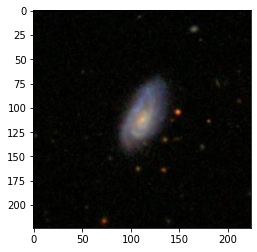

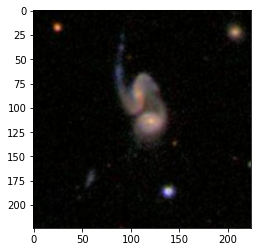

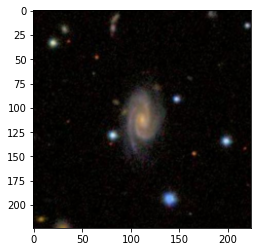

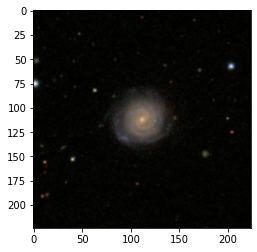

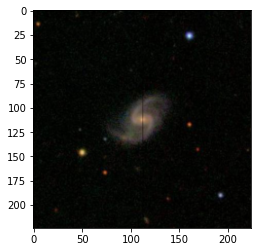

In [19]:
for ii, (i,o) in enumerate(print_test):
  if ii in top5:
        plt.imshow(i.permute((1,2,0)))
        plt.show()

6. Check the torchvision page for the various pretrained models: 
https://pytorch.org/docs/stable/torchvision/models.html

Choose one of the other models (not VGG!), load it into colab, check
the structure of the model, and replace the final layer so that it can
be used for our Spiral Arm challenge (i.e. change the final layer so
it gives one output between 0 and 1). For example, you could look at
the implementation of ResNet and compare to what we made last week,
and you can download a very deep pretrained network with the ResNet
architecture.

In [20]:
resnet = tv.models.resnet18(True)
for p in resnet.parameters():
  p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [21]:
resnet.fc = th.nn.Sequential(th.nn.Linear(512,1), th.nn.Sigmoid())

Now train your chosen network and compare to the VGG network. 
(As always, hyperparameter optimization may be important to 
get the network to train well)

In [22]:
params = []
for p in resnet.parameters():
  if p.requires_grad:
    params.append(p)
optim = th.optim.Adam(params, lr=fl_lr)
loss = th.nn.MSELoss()
d = th.device('cuda')
resnet = resnet.to(d)
dtrain, dtest = [], []
for epoch in range(1):
  tl,tn = 0.,0.
  for ii, (i, o) in enumerate(zoo_train):
    _ = resnet.train()
    i,o = i.to(d), o.float().to(d)
    optim.zero_grad()
    l = loss(resnet(i), o)
    l.backward()
    optim.step()
    tl+=l.item()*i.size(0)
    tn+=i.size(0)
    if (ii+1) % 1000 == 0:
      print("epoch", epoch, "batch", ii, tl/tn)
      dtrain.append(tl/tn)
      tl,tn = 0.,0.
      _ = resnet.eval()
      for i, o in zoo_test:
        with th.no_grad():
          l = loss(resnet(i.to(d)), o.to(d))
        tl+=l.item()*i.size(0)
        tn+=i.size(0)
      dtest.append(tl/tn)
      print(" test", epoch, "batch", ii, tl/tn)
      tl,tn = 0.,0.

print("Done")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0 batch 999 0.0860233599236235


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


 test 0 batch 999 0.08429689238584043
epoch 0 batch 1999 0.08575249648466707
 test 0 batch 1999 0.08363675942389455
epoch 0 batch 2999 0.08876491806283593
 test 0 batch 2999 0.09502132805359209
epoch 0 batch 3999 0.08433359722793102
 test 0 batch 3999 0.08578650557256502
epoch 0 batch 4999 0.08681619951175526
 test 0 batch 4999 0.08693406013814227
epoch 0 batch 5999 0.08385180034954101
 test 0 batch 5999 0.08536865855001001
Done


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [23]:
for p in resnet.parameters():
  p.requires_grad = True
# New optimizer which can optimize the whole network
optim = th.optim.Adam(resnet.parameters(), lr=ft_lr)
loss = th.nn.MSELoss()
d = th.device('cuda')
resnet = resnet.to(d)
dtrain, dtest = [], []
for epoch in range(1):
  tl,tn = 0.,0.
  for ii, (i, o) in enumerate(zoo_train):
    _ = resnet.train()
    i,o = i.to(d), o.float().to(d)
    optim.zero_grad()
    l = loss(resnet(i), o)
    l.backward()
    optim.step()
    tl+=l.item()*i.size(0)
    tn+=i.size(0)
    if (ii+1) % 1000 == 0:
      print("epoch", epoch, "batch", ii, tl/tn)
      dtrain.append(tl/tn)
      tl,tn = 0.,0.
      _ = resnet.eval()
      for i, o in zoo_test:
        with th.no_grad():
          l = loss(resnet(i.to(d)), o.to(d))
        tl+=l.item()*i.size(0)
        tn+=i.size(0)
      dtest.append(tl/tn)
      print(" test", epoch, "batch", ii, tl/tn)
      tl,tn = 0.,0.

print("Done")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0 batch 999 0.0804514245716855


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


 test 0 batch 999 0.08352243617943084
epoch 0 batch 1999 0.0787938931779936
 test 0 batch 1999 0.08430863210056654
epoch 0 batch 2999 0.07991588381724432
 test 0 batch 2999 0.08454041502709315
epoch 0 batch 3999 0.07659263269603253
 test 0 batch 3999 0.08357426618272504
epoch 0 batch 4999 0.07644625973608345
 test 0 batch 4999 0.08488361228710901
epoch 0 batch 5999 0.074233873358462
 test 0 batch 5999 0.08254841429213597
Done


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


VGG11


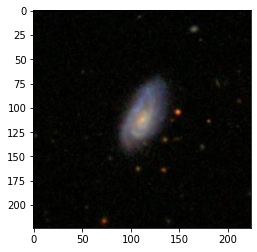

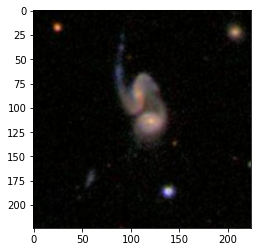

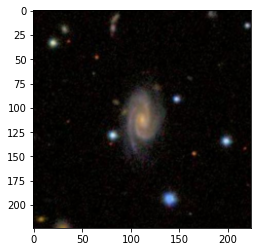

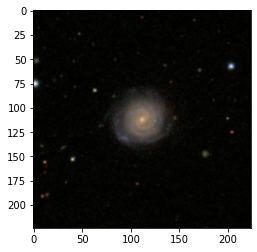

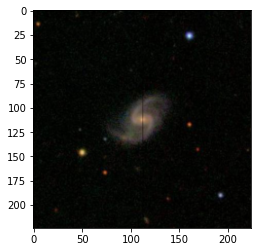

resnet18


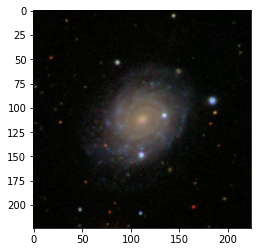

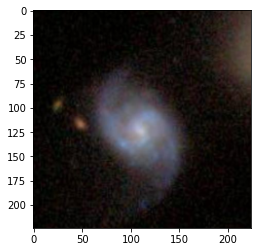

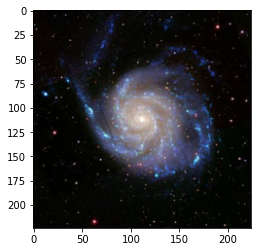

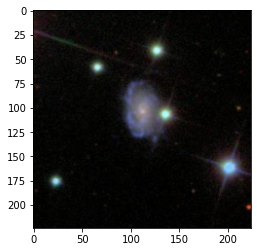

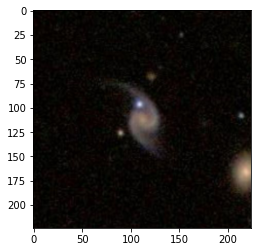

In [24]:
values = []
_ = resnet.eval()
for ii, (i, o) in enumerate(zoo_test):
  with th.no_grad():
    for val in resnet(i.to(d)):
      values.append(val)
values = th.tensor(values).to('cpu')
restop5 = th.argsort(values)[-5:]

print('VGG11')
#Vgg11
for ii, (i,o) in enumerate(print_test):
  if ii in top5:
        plt.imshow(i.permute((1,2,0)))
        plt.show()

print('resnet18')
#resnet18
for ii, (i,o) in enumerate(print_test):
  if ii in restop5:
        plt.imshow(i.permute((1,2,0)))
        plt.show()